In [22]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from util.network import FrozenLakeNet, TaxiNet, CliffWalkingNet
from collections import defaultdict
import argparse

In [23]:
# Função para criar o objeto de configuração
def get_config(env_name, count_episodes, seed, gamma, tau, alpha, lr, steps, hidden_size=256):
    parser = argparse.ArgumentParser(description='RL')
    parser.add_argument("--run_name", type=str, default=f"{env_name}-DQN-FQI", help="Run name, default: CQL-DQN")
    parser.add_argument("--env", type=str, default=env_name, help="Gym environment name, default: CartPole-v0")
    parser.add_argument("--episodes", type=int, default=count_episodes, help="Number of episodes, default: 200")
    parser.add_argument("--seed", type=int, default=seed, help="Seed, default: 1")
    parser.add_argument("--steps", type=int, default=steps, help="Saves the network every x epochs, default: 25")
    parser.add_argument("--gamma", type=float, default=gamma, help="Discount factor, default: 0.99")
    parser.add_argument("--tau", type=float, default=tau, help="Target network update rate, default: 0.005")
    parser.add_argument("--alpha", type=float, default=alpha, help="CQL weight, default: 1.0")
    parser.add_argument("--lr", type=float, default=lr, help="Learning rate, default: 0.001")
    parser.add_argument("--hidden_size", type=int, default=hidden_size, help="Hidden layer size, default: 256")
    
    args, _ = parser.parse_known_args()
    return args

In [24]:
# Função para avaliar o desempenho de um modelo
def evaluate_model(config, env, model):
    total_rewards = []
    success_count = 0  # Contador de episódios bem-sucedidos
    steps_per_episode = []  # Lista para armazenar o número de passos por episódio

    for i in range(config.episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        step = 0
        while not done:
            state_tensor = torch.tensor([state], dtype=torch.long)
            state_tensor = to_one_hot(state_tensor, model.input_size)[0].float().unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            step += 1
            if step == 10000:  # Limite de passos por episódio
                break

        total_rewards.append(episode_reward)
        steps_per_episode.append(step)

        # Verificar se o episódio foi bem-sucedido
        if done and not truncated:  # Episódio concluído sem truncamento
            success_count += 1

    avg_reward = np.mean(total_rewards)
    success_rate = success_count / config.episodes  # Taxa de sucesso
    avg_steps = np.mean(steps_per_episode)  # Média de passos por episódio

    return avg_reward, success_rate, avg_steps

In [25]:
# Função para comparar os métodos
def compare_methods(env_name, env, hidden_size, model_class, cql_model_path, fqi_model_path):
    # Criar configuração para o ambiente
    config = get_config(env_name, COUNT_EPISODES, SEED, GAMMA, TAU, ALPHA, LEARNING_RATE, STEPS, hidden_size)

    # Carregar modelos
    cql_model = model_class(env.observation_space.n, env.action_space.n, hidden_size)
    cql_model.load_state_dict(torch.load(cql_model_path))
    cql_model.eval()

    fqi_model = model_class(env.observation_space.n, env.action_space.n, hidden_size)
    fqi_model.load_state_dict(torch.load(fqi_model_path))
    fqi_model.eval()

    # Avaliar modelos
    cql_reward, cql_success_rate, cql_steps = evaluate_model(config, env, cql_model)
    fqi_reward, fqi_success_rate, fqi_steps = evaluate_model(config, env, fqi_model)

    # Retornar resultados
    return {
        "CQL-DQN": {"reward": cql_reward, "success_rate": cql_success_rate, "steps": cql_steps},
        "FQI-DQN": {"reward": fqi_reward, "success_rate": fqi_success_rate, "steps": fqi_steps}
    }

In [26]:
# Configurações globais
COUNT_EPISODES = 50
SEED = 777
GAMMA = 0.99  # Fator de desconto
TAU = 5e-3    # Taxa de atualização da target_network
ALPHA = 1     # Peso do termo CQL
LEARNING_RATE = 3e-4  # Taxa de aprendizado para o otimizador
STEPS = 100_000

In [27]:
# Configurações para cada ambiente
env_configs = {
    "FrozenLake-v1": {
        "hidden_size": 128,
        "model_class": FrozenLakeNet,
        "cql_model_path": "trained_models/FrozenLake-v1CQL-DQN.pth",
        "fqi_model_path": "trained_models/FrozenLake-v1FQI-DQN.pth"
    },
    "Taxi-v3": {
        "hidden_size": 512,
        "model_class": TaxiNet,
        "cql_model_path": "trained_models/Taxi-v3CQL-DQN.pth",
        "fqi_model_path": "trained_models/Taxi-v3FQI-DQN.pth"
    },
    "CliffWalking-v0": {
        "hidden_size": 256,
        "model_class": CliffWalkingNet,
        "cql_model_path": "trained_models/CliffWalking-v0CQL-DQN.pth",
        "fqi_model_path": "trained_models/CliffWalking-v0FQI-DQN.pth"
    }
}

# Dicionário para armazenar os resultados
results = {}

In [28]:
# Comparar métodos para cada ambiente
for env_name, config in env_configs.items():
    env = gym.make(env_name)
    results[env_name] = compare_methods(env_name, env, config["hidden_size"], config["model_class"], config["cql_model_path"], config["fqi_model_path"])

    # Exibir resultados para o ambiente atual
    print(f"Ambiente: {env_name}")
    print(f"CQL-DQN - Recompensa Média: {results[env_name]['CQL-DQN']['reward']}, Taxa de Sucesso: {results[env_name]['CQL-DQN']['success_rate']}, Passos Médios: {results[env_name]['CQL-DQN']['steps']}")
    print(f"FQI-DQN - Recompensa Média: {results[env_name]['FQI-DQN']['reward']}, Taxa de Sucesso: {results[env_name]['FQI-DQN']['success_rate']}, Passos Médios: {results[env_name]['FQI-DQN']['steps']}")
    print("-" * 40)

Ambiente: FrozenLake-v1
CQL-DQN - Recompensa Média: 0.42, Taxa de Sucesso: 0.9, Passos Médios: 43.2
FQI-DQN - Recompensa Média: 0.74, Taxa de Sucesso: 0.9, Passos Médios: 46.82
----------------------------------------
Ambiente: Taxi-v3
CQL-DQN - Recompensa Média: -1993.8, Taxa de Sucesso: 0.8, Passos Médios: 2010.6
FQI-DQN - Recompensa Média: -6196.66, Taxa de Sucesso: 0.38, Passos Médios: 6204.64
----------------------------------------
Ambiente: CliffWalking-v0
CQL-DQN - Recompensa Média: -13.0, Taxa de Sucesso: 1.0, Passos Médios: 13.0
FQI-DQN - Recompensa Média: -13.0, Taxa de Sucesso: 1.0, Passos Médios: 13.0
----------------------------------------


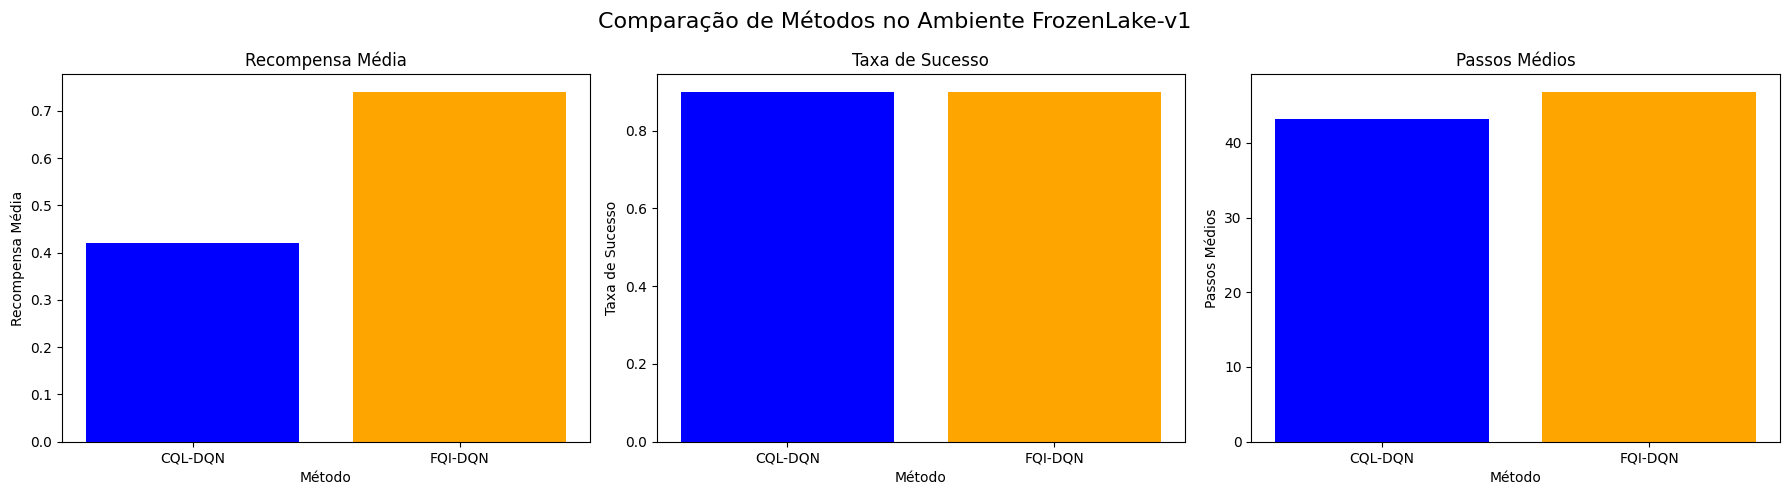

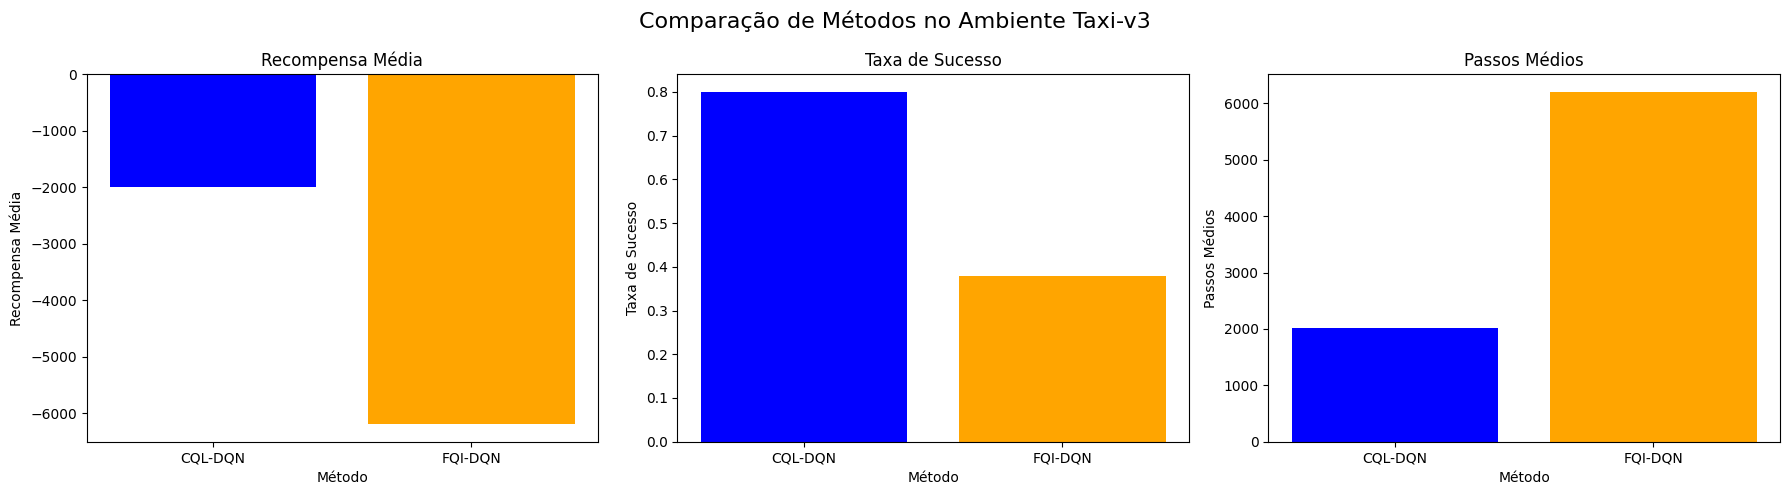

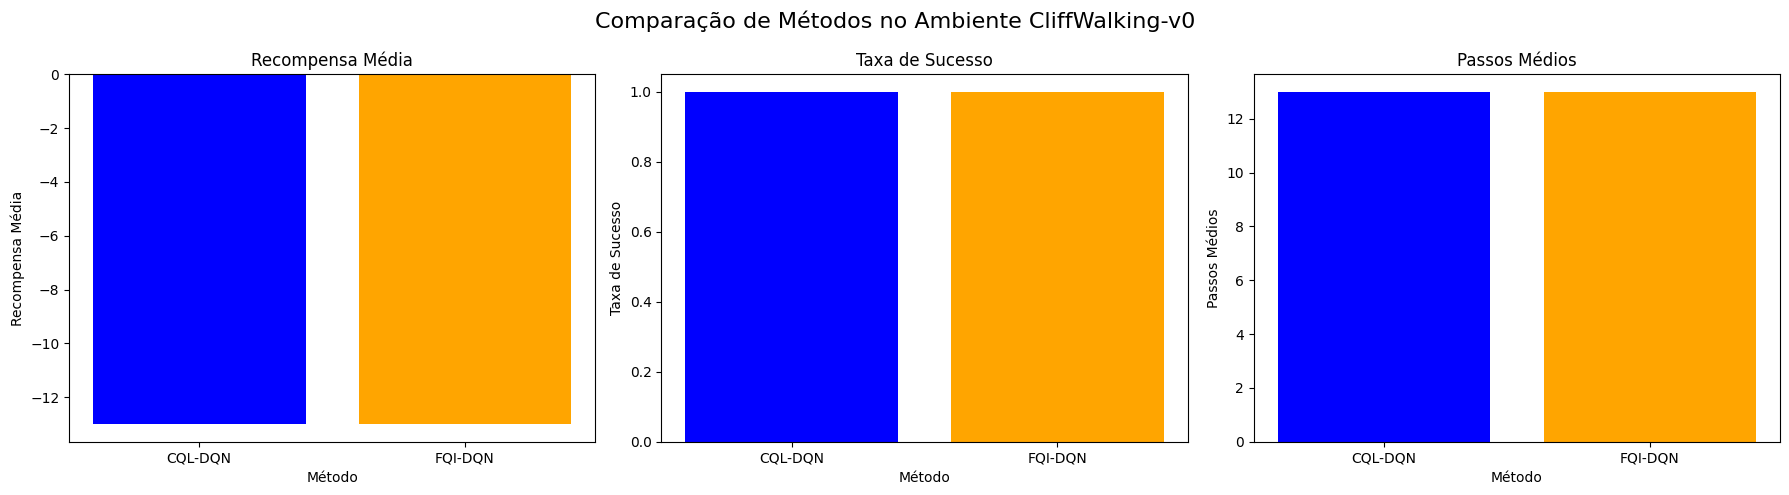

In [29]:
# Plotar gráficos individuais para cada ambiente
for env_name in env_configs.keys():
    methods = ["CQL-DQN", "FQI-DQN"]
    metrics = ["reward", "success_rate", "steps"]
    metric_labels = ["Recompensa Média", "Taxa de Sucesso", "Passos Médios"]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Comparação de Métodos no Ambiente {env_name}", fontsize=16)

    for i, metric in enumerate(metrics):
        values = [results[env_name][method][metric] for method in methods]
        axs[i].bar(methods, values, color=['blue', 'orange'])
        axs[i].set_title(metric_labels[i])
        axs[i].set_ylabel(metric_labels[i])
        axs[i].set_xlabel("Método")

    plt.tight_layout()
    plt.show()